In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from tqdm import tqdm
import dill
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as mlines
from matplotlib.patches import FancyArrowPatch
import seaborn as sns
import torch
from torch.distributions import MultivariateNormal
from sbi.inference import FMPE, SNPE, NPSE
from sbi.analysis import pairplot
from sbi.utils import BoxUniform
import sbibm
from sklearn.linear_model import LogisticRegression
from lf2i.inference import LF2I
from lf2i.test_statistics.posterior import Posterior
from lf2i.test_statistics.waldo import Waldo
from lf2i.calibration.critical_values import train_qr_algorithm
from lf2i.utils.other_methods import hpd_region
from lf2i.plot.parameter_regions import plot_parameter_regions
from lf2i.plot.coverage_diagnostics import coverage_probability_plot
from lf2i.plot.power_diagnostics import set_size_plot
from tsi.common.monotone_nn import train_monotonic_nn, MonotonicNN
from tsi.common.utils import IntList, TrainingLogger
from tsi.temp.utils import kdeplots2D

2025-10-24 15:57:37.318348: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-24 15:57:37.318443: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-24 15:57:37.319854: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-24 15:57:37.326623: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-24 15:57:38.509183: W tensorflow/compiler/tf2

In [3]:
### Settings
POI_DIM = 2  # parameter of interest
PRIOR_LOC = [0, 0]
PRIOR_VAR = 2.0 # (6*np.sqrt(2.0))**2
POI_BOUNDS = {r'$\theta_1$': (-10, 10), r'$\theta_2$': (-10, 10)}
PRIOR = MultivariateNormal(
    loc=torch.Tensor(PRIOR_LOC), covariance_matrix=PRIOR_VAR*torch.eye(n=POI_DIM)
)

B = 50_000  # num simulations to estimate posterior and test statistics
B_PRIME = 1_000  # num simulations to estimate critical values
B_DOUBLE_PRIME = 30_000  # num simulations to do diagnostics
EVAL_GRID_SIZE = 30_000  # num evaluation points over parameter space to construct confidence sets
CONFIDENCE_LEVEL = 0.954, 0.683  # 0.99

# REFERENCE = BoxUniform(
#     low=torch.tensor((POI_BOUNDS[r'$\theta_1$'][0]-1, POI_BOUNDS[r'$\theta_2$'][0]-1)),
#     high=torch.tensor((POI_BOUNDS[r'$\theta_1$'][1]+1, POI_BOUNDS[r'$\theta_2$'][1]+1))
# )
REFERENCE = PRIOR
EVAL_GRID_DISTR = BoxUniform(
    low=torch.tensor((POI_BOUNDS[r'$\theta_1$'][0], POI_BOUNDS[r'$\theta_2$'][0])),
    high=torch.tensor((POI_BOUNDS[r'$\theta_1$'][1], POI_BOUNDS[r'$\theta_2$'][1]))
)

POSTERIOR_KWARGS = {
    # 'norm_posterior': None
}
FREB_KWARGS = {
    'num_augment': 10,
    'hidden_layers': [128, 64],
    'DEVICE': 'cpu',
    'batch_size': 128,
    'num_workers': 30,
    'lr': 1e-3,
    'weight_decay': 1e-5,
    'n_epochs': 100,
}
DEVICE = 'cpu'
task = sbibm.get_task('gaussian_mixture')
simulator = task.get_simulator()

/home/export/jcarzon/anaconda3/envs/tsi/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/export/jcarzon/anaconda3/envs/tsi/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/export/jcarzon/anaconda3/envs/tsi/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/export/jcarzon/anaconda3/envs/tsi/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na 

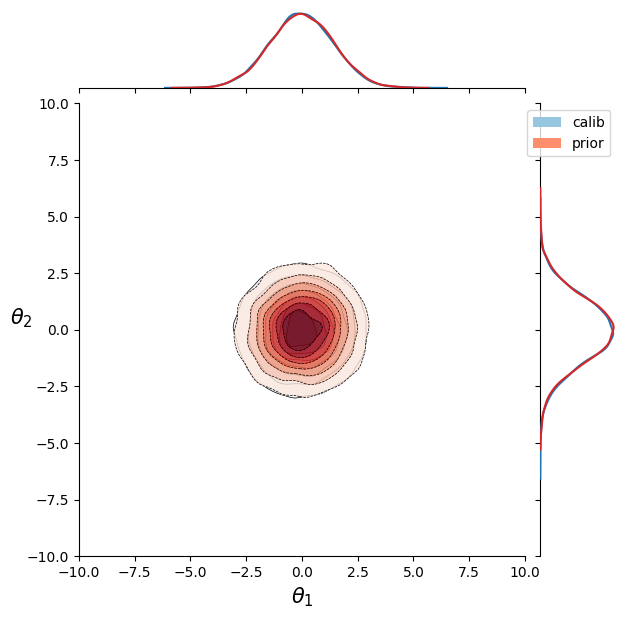

In [4]:
kdeplots2D(
    [REFERENCE.sample(sample_shape=(10_000, )), PRIOR.sample(sample_shape=(10_000, ))],
    true_theta=None,
    plot_marginals=True,
    xlim=(POI_BOUNDS[r'$\theta_1$'][0], POI_BOUNDS[r'$\theta_2$'][1]), 
    ylim=(POI_BOUNDS[r'$\theta_1$'][0], POI_BOUNDS[r'$\theta_2$'][1]),
    names=['calib', 'prior'],
    axis_labels=[r'$\theta_1$', r'$\theta_2$']
)

# NDE

In [5]:
# try:
#     with open('results/test/fmpe_strong_prior.pkl', 'rb') as f:
#         fmpe_posterior = dill.load(f)
# except:
#     b_params = PRIOR.sample(sample_shape=(B, ))
#     b_samples = simulator(b_params)
#     b_params.shape, b_samples.shape
#     fmpe = fmpe(
#         prior=PRIOR,
#         density_estimator='maf',
#         device='cpu'
#     )

#     _ = fmpe.append_simulations(b_params, b_samples).train()
#     fmpe_posterior = fmpe.build_posterior()
#     with open('results/test/fmpe_strong_prior.pkl', 'wb') as f:
#         dill.dump(fmpe_posterior, f)

In [6]:
try:
    with open('results/test/fmpe_strong_prior.pkl', 'rb') as f:
        fmpe_posterior = dill.load(f)
except:
    b_params = PRIOR.sample(sample_shape=(B, ))
    b_samples = simulator(b_params)
    b_params.shape, b_samples.shape
    fmpe = FMPE(
        prior=PRIOR,
        device='cpu'
    )

    _ = fmpe.append_simulations(b_params, b_samples).train()
    fmpe_posterior = fmpe.build_posterior()
    with open('results/test/fmpe_strong_prior.pkl', 'wb') as f:
        dill.dump(fmpe_posterior, f)

 Neural network successfully converged after 92 epochs.

# FreB

In [7]:
b_prime_params = REFERENCE.sample(sample_shape=(B_PRIME, ))
b_prime_samples = simulator(b_prime_params)
b_prime_params.shape, b_prime_samples.shape
try:
    with open('results/test/obs_x_theta.pkl', 'rb') as f:
        examples = dill.load(f)
        true_theta = examples['true_theta']
        obs_x = examples['obs_x']
except:
    true_theta = torch.Tensor([[-8.5, -8.5], [-8.5, 8.5], [8.5, -8.5], [8.5, 8.5], [0., 0.], [0., 0.], [0., 0.], [0., 0.]])
    obs_x = simulator(true_theta)
    with open('results/test/obs_x_theta.pkl', 'wb') as f:
        dill.dump({
            'true_theta': true_theta,
            'obs_x': obs_x
        }, f)

In [8]:
try:
    with open('results/test/lf2i_strong_prior.pkl', 'rb') as f:
        lf2i = dill.load(f)
    confidence_sets = lf2i.inference(
        x=obs_x,
        evaluation_grid=EVAL_GRID_DISTR.sample(sample_shape=(EVAL_GRID_SIZE, )),
        confidence_level=CONFIDENCE_LEVEL,
        calibration_method='p-values',
        calibration_model='logistic',
        calibration_model_kwargs={
            # 'cv': {'iterations': [100, 300, 500, 700, 1000], 'depth': [1, 3, 5, 7, 9]},
            # 'n_iter': 25
            # 'cv': {'iterations': [100], 'depth': [3]},
            # 'n_iter': 1
        },
        T_prime=(b_prime_params, b_prime_samples),
        retrain_calibration=False
    )
except:
    lf2i = LF2I(test_statistic=Posterior(poi_dim=2, estimator=fmpe_posterior, **POSTERIOR_KWARGS))
    confidence_sets = lf2i.inference(
        x=obs_x,
        evaluation_grid=EVAL_GRID_DISTR.sample(sample_shape=(EVAL_GRID_SIZE, )),
        confidence_level=CONFIDENCE_LEVEL,
        calibration_method='p-values',
        calibration_model='logistic',
        calibration_model_kwargs={
            # 'cv': {'iterations': [100, 300, 500, 700, 1000], 'depth': [1, 3, 5, 7, 9]},
            # 'n_iter': 25
            # 'cv': {'iterations': [100], 'depth': [3]},
            # 'n_iter': 1
        },
        T_prime=(b_prime_params, b_prime_samples),
        retrain_calibration=False
    )
    with open('results/test/lf2i_strong_prior.pkl', 'wb') as f:
        dill.dump(lf2i, f)

remaining = len(obs_x)
credible_sets = []
for x in obs_x:  # torch.vstack([task.get_observation(i) for i in range(1, 11)])
    print(f'Remaining: {remaining}', flush=True)
    credible_sets_x = []
    for cl in CONFIDENCE_LEVEL:
        actual_cred_level, credible_set = hpd_region(
            posterior=fmpe_posterior,
            param_grid=EVAL_GRID_DISTR.sample(sample_shape=(EVAL_GRID_SIZE, )),
            x=x.reshape(-1, ),
            credible_level=cl,
            num_level_sets=10_000,
            **POSTERIOR_KWARGS
        )
        #print(actual_cred_level, flush=True)
        credible_sets_x.append(credible_set)
    credible_sets.append(credible_sets_x)
    remaining -= 1


Calibration ...


Evaluating posterior for 1000 points ...: 100%|██████████| 1000/1000 [18:59<00:00,  1.14s/it]


Retraining calibration...



Constructing confidence regions ...


Evaluating posterior for 8 points ...: 100%|██████████| 8/8 [02:24<00:00, 18.11s/it]


Computing p-values...

Creating set 0...

Creating set 1...
Remaining: 8


Remaining: 7
Remaining: 6
Remaining: 5
Remaining: 4
Remaining: 3
Remaining: 2
Remaining: 1


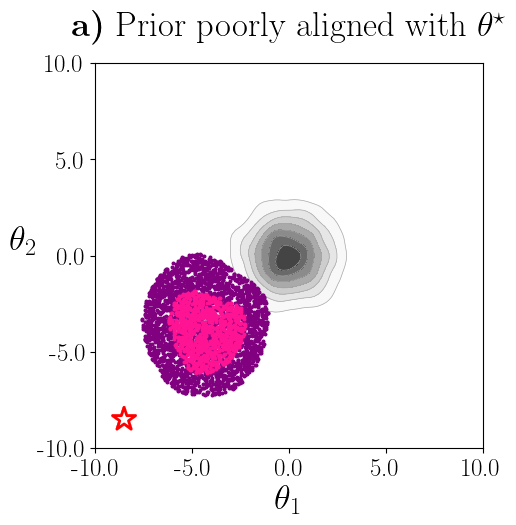

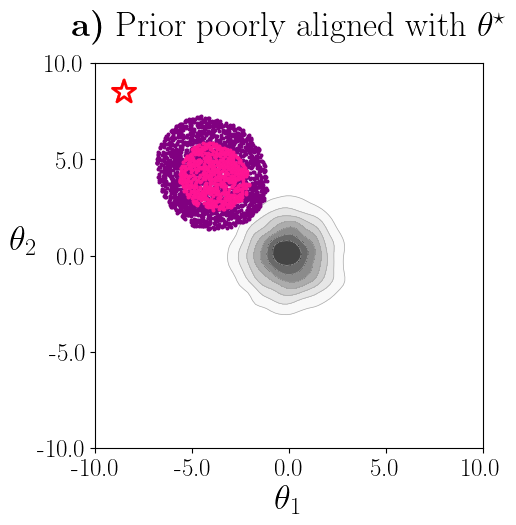

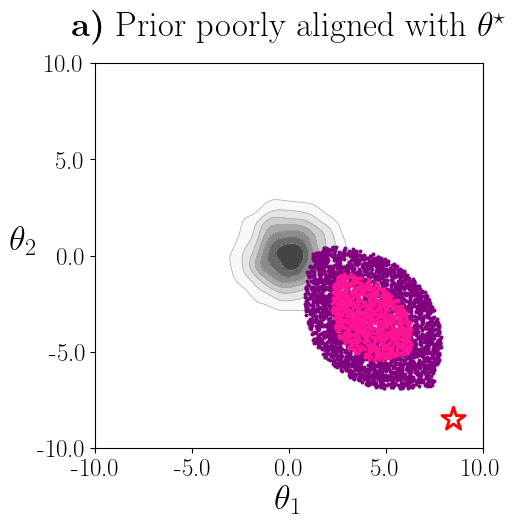

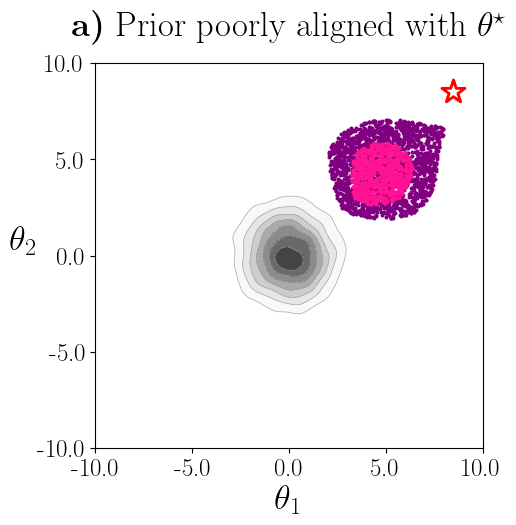

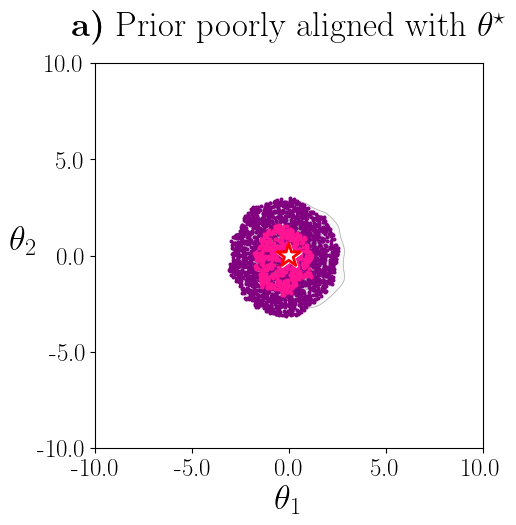

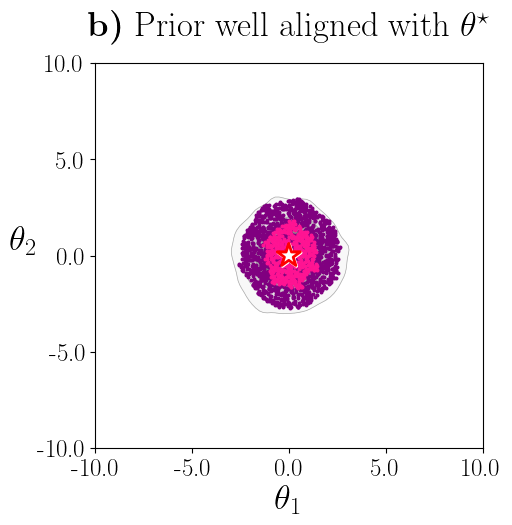

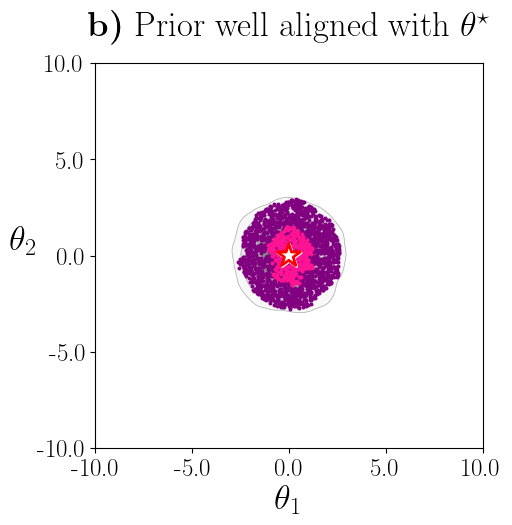

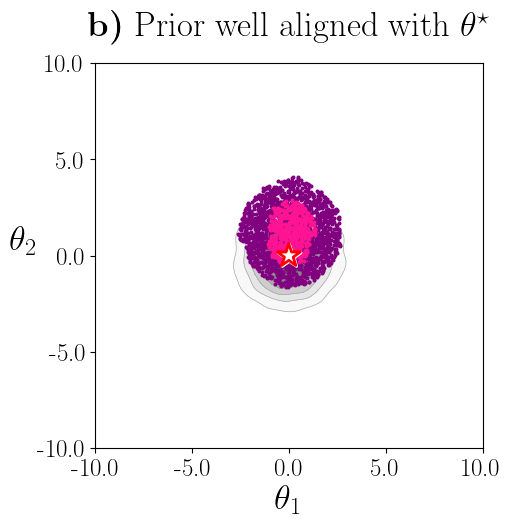

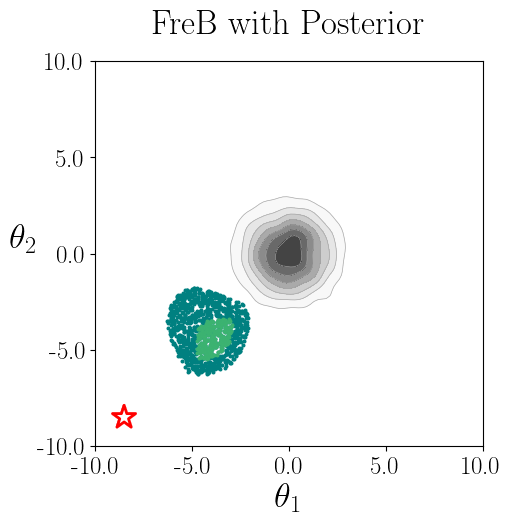

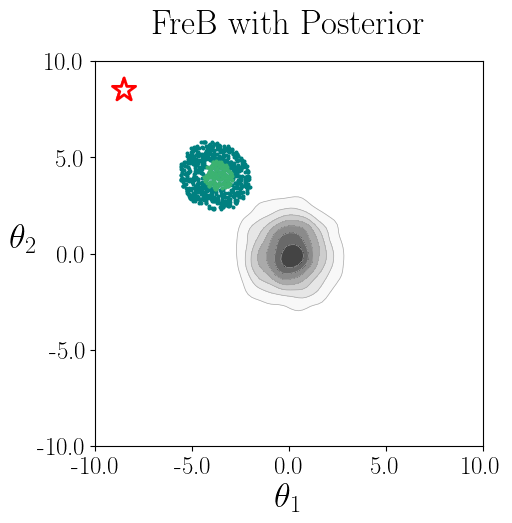

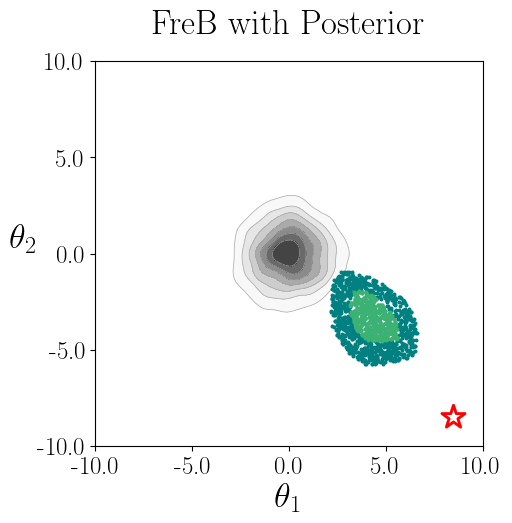

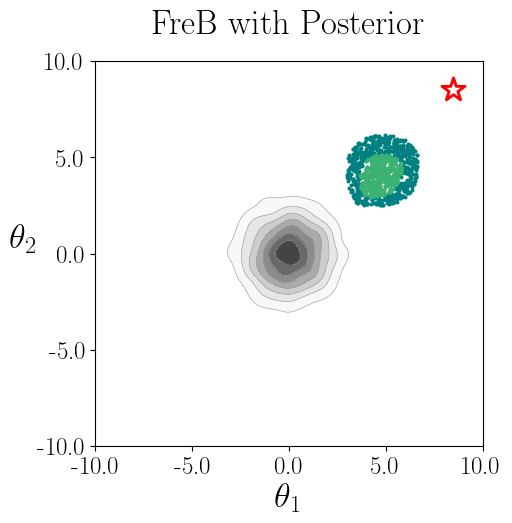

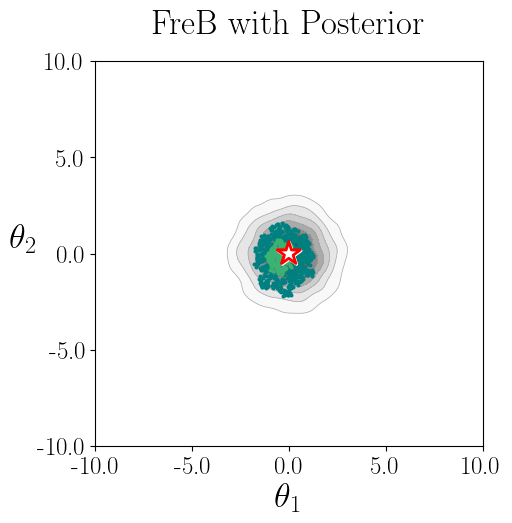

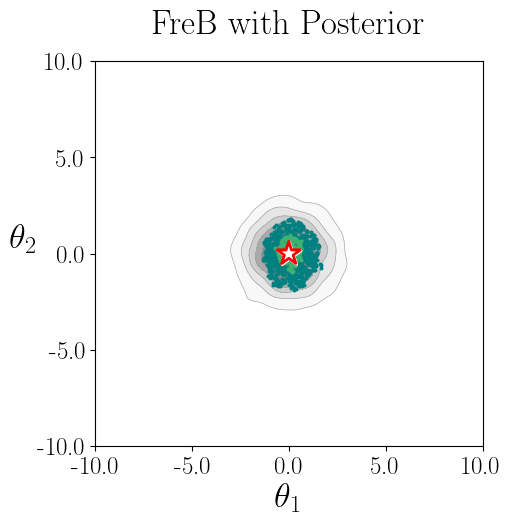

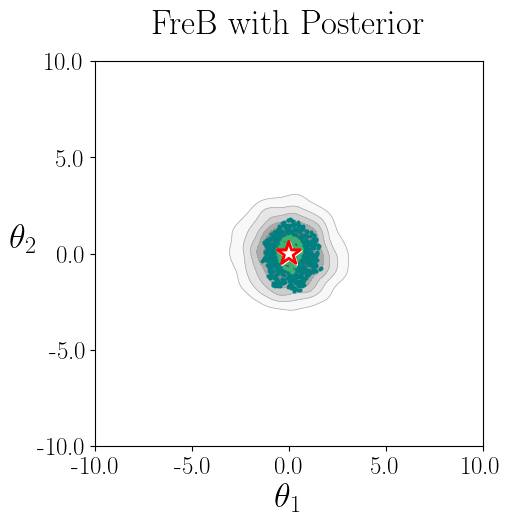

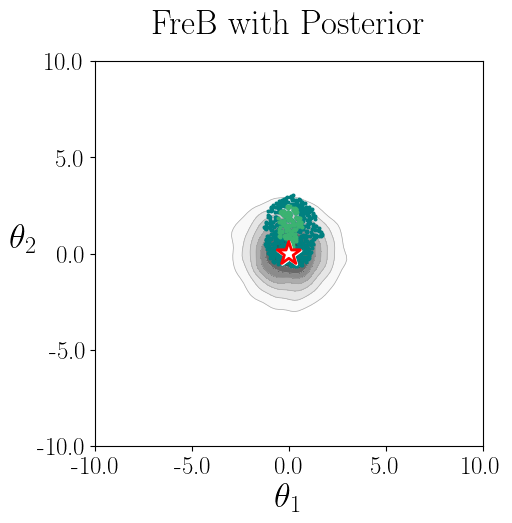

In [10]:
plt.rc('text', usetex=True)  # Enable LaTeX
plt.rc('font', family='serif')  # Use a serif font (e.g., Computer Modern)
plt.rcParams['text.latex.preamble'] = r'''
    \usepackage{amsmath}  % For \mathbb
    \usepackage{amssymb}  % For \mathbb
    \usepackage{bm}       % For bold math symbols
    \usepackage{underscore} % If underscores are needed
'''

for idx_obs, _ in enumerate(obs_x):

    if idx_obs <= 4:
        title = r'\textbf{a)} Prior poorly aligned with $\theta^{\star}$'
    else:
        title = r'\textbf{b)} Prior well aligned with $\theta^{\star}$'

    plot_parameter_regions(
        *credible_sets[idx_obs], #*[confidence_sets[j][idx_obs] for j in range(len(CONFIDENCE_LEVEL))],
        param_dim=2,
        true_parameter=true_theta[idx_obs, :],
        prior_samples=PRIOR.sample(sample_shape=(5_000, )).numpy(),
        parameter_space_bounds={
            r'$\theta_1$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_1$'])), 
            r'$\theta_2$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_2$'])), 
        },
        # parameter_space_bounds={
        #     r'$\theta_1$': dict(zip(['low', 'high'], [-1.0, 1.0])), 
        #     r'$\theta_2$': dict(zip(['low', 'high'], [-1.0, 1.0])), 
        # },
        colors=[
            'purple', 'deeppink', # 'hotpink',  # credible sets
            #'teal', 'mediumseagreen', 'darkseagreen', # confidence sets
        ],
        region_names=[
            *[f'HPD {int(cl*100):.0f}\%' for cl in CONFIDENCE_LEVEL],
            #*[f'CS {cl*100:.1f}%' for cl in CONFIDENCE_LEVEL],
        ],
        labels=[r'$\theta_1$', r'$\theta_2$'],
        linestyles=['-', '--'],  # , ':'
        param_names=[r'$\theta_1$', r'$\theta_2$'],
        alpha_shape=False,
        alpha=3,
        scatter=True,
        figsize=(5, 5),
        # save_fig_path=f'results/test/hpd{idx_obs}.png',
        remove_legend=True,
        title=title,
        custom_ax=None
    )

for idx_obs, _ in enumerate(obs_x):

    plot_parameter_regions(
        *[confidence_sets[j][idx_obs] for j in range(len(CONFIDENCE_LEVEL))],
        param_dim=2,
        true_parameter=true_theta[idx_obs, :],
        prior_samples=PRIOR.sample(sample_shape=(5_000, )).numpy(),
        parameter_space_bounds={
            r'$\theta_1$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_1$'])), 
            r'$\theta_2$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_2$'])), 
        },
        colors=[
            #'purple', 'deeppink', 'hotpink',  # credible sets
            'teal', 'mediumseagreen', # 'darkseagreen', # confidence sets
        ],
        region_names=[
            #*[f'HPD {cl*100:.1f}%' for cl in CONFIDENCE_LEVEL],
            *[f'FreB {int(cl*100):.0f}\%' for cl in CONFIDENCE_LEVEL],
        ],
        labels=[r'$\theta_1$', r'$\theta_2$'],
        linestyles=['-', '--'],  # , ':'
        param_names=[r'$\theta_1$', r'$\theta_2$'],
        alpha_shape=False,
        alpha=3,
        scatter=True,
        figsize=(5, 5),
        # save_fig_path=f'results/test/freb{idx_obs}.png',
        remove_legend=True,
        title='FreB with Posterior',
        custom_ax=None
    )

In [ ]:
try:
    with open('results/test/diagn_confset_strong_prior.pkl', 'rb') as f:
        diagn_objects = dill.load(f)
    with open('results/test/diagn_confset_strong_prior_waldo.pkl', 'rb') as f:
        diagn_objectsw = dill.load(f)
    with open('results/test/diagn_cred_strong_prior.pkl', 'rb') as f:
        diagn_objects_cred = dill.load(f)
    with open('results/test/b_double_prime.pkl', 'rb') as f:
        b_double_prime = dill.load(f)
        b_double_prime_params, b_double_prime_samples = b_double_prime['params'], b_double_prime['samples']
except:
    b_double_prime_params = REFERENCE.sample(sample_shape=(B_DOUBLE_PRIME, ))
    b_double_prime_samples = simulator(b_double_prime_params)
    b_double_prime_params.shape, b_double_prime_samples.shape
    with open('results/test/b_double_prime.pkl', 'wb') as f:
        dill.dump({
            'params': b_double_prime_params,
            'samples': b_double_prime_samples
        }, f)

    diagn_objects = {}
    for cl in CONFIDENCE_LEVEL[:1]:  # 0.954
        print(cl, flush=True)
        diagnostics_estimator_confset, out_parameters_confset, mean_proba_confset, upper_proba_confset, lower_proba_confset = lf2i.diagnostics(
            region_type='lf2i',
            confidence_level=cl,
            calibration_method='p-values',
            coverage_estimator='splines',
            T_double_prime=(b_double_prime_params, b_double_prime_samples),
        )
        diagn_objects[cl] = (diagnostics_estimator_confset, out_parameters_confset, mean_proba_confset, upper_proba_confset, lower_proba_confset)
    with open('results/test/diagn_confset_strong_prior.pkl', 'wb') as f:
        dill.dump(diagn_objects, f)

    plt.scatter(out_parameters_confset[:, 0], out_parameters_confset[:, 1], c=mean_proba_confset)
    plt.title('Coverage of FreB confidence sets')
    plt.clim(vmin=0, vmax=1)
    plt.colorbar()
    plt.savefig('results/test/freb_coverage')
    plt.close()

    diagn_objectsw = {}
    for cl in CONFIDENCE_LEVEL[:1]:  # 0.954
        print(cl, flush=True)
        diagnostics_estimator_confset, out_parameters_confset, mean_proba_confset, upper_proba_confset, lower_proba_confset = lf2iw.diagnostics(
            region_type='lf2i',
            confidence_level=cl,
            calibration_method='p-values',
            coverage_estimator='splines',
            T_double_prime=(b_double_prime_params, b_double_prime_samples),
        )
        diagn_objects[cl] = (diagnostics_estimator_confset, out_parameters_confset, mean_proba_confset, upper_proba_confset, lower_proba_confset)
    with open('results/test/diagn_confset_strong_prior_waldo.pkl', 'wb') as f:
        dill.dump(diagn_objectsw, f)

    plt.scatter(out_parameters_confset[:, 0], out_parameters_confset[:, 1], c=mean_proba_confset)
    plt.title('Coverage of Waldo confidence sets')
    plt.clim(vmin=0, vmax=1)
    plt.colorbar()
    plt.savefig('results/test/waldo_coverage')
    plt.close()

    diagn_objects_cred = {}
    size_grid_for_sizes = 5_000
    for cl in CONFIDENCE_LEVEL[:1]:  # 0.954
        print(cl, flush=True)
        diagnostics_estimator_credible, out_parameters_credible, mean_proba_credible, upper_proba_credible, lower_proba_credible, sizes = lf2i.diagnostics(
            region_type='posterior',
            confidence_level=cl,
            coverage_estimator='splines',
            T_double_prime=(b_double_prime_params, b_double_prime_samples),
            posterior_estimator=lf2i.test_statistic.estimator,
            evaluation_grid=EVAL_GRID_DISTR.sample(sample_shape=(size_grid_for_sizes, )),
            num_level_sets=5_000,
            **POSTERIOR_KWARGS
        )
        diagn_objects_cred[cl] = (diagnostics_estimator_credible, out_parameters_credible, mean_proba_credible, upper_proba_credible, lower_proba_credible, sizes)
    with open('results/test/diagn_cred_strong_prior.pkl', 'wb') as f:
        dill.dump(diagn_objects_cred, f)

    plt.scatter(out_parameters_credible[:, 0], out_parameters_credible[:, 1], c=mean_proba_credible)
    plt.title('Coverage of credible regions')
    plt.clim(vmin=0, vmax=1)
    plt.colorbar()
    plt.savefig('results/test/hpd_coverage')
    plt.close()

In [ ]:
try:
    with open('results/test/confidence_sets_for_size.pkl', 'rb') as f:
        confidence_sets_for_size = dill.load(f)
    with open('results/test/set_for_size.pkl', 'rb') as f:
        set_for_size = dill.load(f)
        params_for_size = set_for_size['params']
        samples_for_size = set_for_size['samples']
except:
    params_for_size = EVAL_GRID_DISTR.sample(sample_shape=(B_DOUBLE_PRIME, ))
    samples_for_size = simulator(params_for_size)
    params_for_size.shape, samples_for_size.shape
    with open('results/test/set_for_size.pkl', 'wb') as f:
        dill.dump({
            'params': params_for_size,
            'samples': samples_for_size
        }, f)

    size_grid_for_sizes = 5_000
    confidence_sets_for_size = lf2i.inference(
        x=samples_for_size,
        evaluation_grid=EVAL_GRID_DISTR.sample(sample_shape=(size_grid_for_sizes, )),
        confidence_level=CONFIDENCE_LEVEL,
        calibration_method='p-values',
    )
    confset_sizes = np.array([100*cs.shape[0]/size_grid_for_sizes for cs in confidence_sets_for_size[0]])
    with open('results/test/confidence_sets_for_size.pkl', 'wb') as f:
        dill.dump(confidence_sets_for_size, f)

    plt.scatter(params_for_size[:, 0], params_for_size[:, 1], c=confset_sizes)
    plt.clim(0, 100)
    plt.colorbar()
    plt.title('FreB sizes, 1-100\%')
    plt.savefig('results/test/freb_sizes_fixed_scale.png')
    plt.close()

    plt.scatter(params_for_size[:, 0], params_for_size[:, 1], c=confset_sizes)
    plt.colorbar()
    plt.title('FreB sizes')
    plt.savefig('results/test/freb_sizes.png')
    plt.close()

In [ ]:
try:
    with open('results/test/confidence_sets_for_size_waldo.pkl', 'rb') as f:
        confidence_sets_for_size = dill.load(f)
except:
    size_grid_for_sizes = 5_000
    confidence_sets_for_size = lf2iw.inference(
        x=samples_for_size,
        evaluation_grid=EVAL_GRID_DISTR.sample(sample_shape=(size_grid_for_sizes, )),
        confidence_level=CONFIDENCE_LEVEL,
        calibration_method='p-values',
    )
    confset_sizes = np.array([100*cs.shape[0]/size_grid_for_sizes for cs in confidence_sets_for_size[0]])
    with open('results/test/confidence_sets_for_size_waldo.pkl', 'wb') as f:
        dill.dump(confidence_sets_for_size, f)

    plt.scatter(params_for_size[:, 0], params_for_size[:, 1], c=confset_sizes)
    plt.clim(0, 100)
    plt.colorbar()
    plt.title('Waldo sizes, 1-100\%')
    plt.savefig('results/test/waldo_sizes_fixed_scale.png')
    plt.close()

    plt.scatter(params_for_size[:, 0], params_for_size[:, 1], c=confset_sizes)
    plt.colorbar()
    plt.title('Waldo sizes')
    plt.savefig('results/test/waldo_sizes.png')
    plt.close()

In [ ]:
plt.rc('text', usetex=True)  # Enable LaTeX
plt.rc('font', family='serif')  # Use a serif font (e.g., Computer Modern)
plt.rcParams['text.latex.preamble'] = r'''
    \usepackage{amsmath}  % For \mathbb
    \usepackage{amssymb}  % For \mathbb
    \usepackage{bm}       % For bold math symbols
    \usepackage{underscore} % If underscores are needed
'''

fig, axs = plt.subplots(2, 3, figsize=(12, 10))

idx_obs = 3
plot_parameter_regions(
    *credible_sets[idx_obs], #*[confidence_sets[j][idx_obs] for j in range(len(CONFIDENCE_LEVEL))],
    param_dim=2,
    true_parameter=true_theta[idx_obs, :],
    prior_samples=PRIOR.sample(sample_shape=(50_000, )).numpy(),
    parameter_space_bounds={
        r'$\theta_1$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_1$'])), 
        r'$\theta_2$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_2$'])), 
    },
    # parameter_space_bounds={
    #     r'$\theta_1$': dict(zip(['low', 'high'], [-1.0, 1.0])), 
    #     r'$\theta_2$': dict(zip(['low', 'high'], [-1.0, 1.0])), 
    # },
    colors=[
        'purple', 'deeppink', # 'hotpink',  # credible sets
        #'teal', 'mediumseagreen', 'darkseagreen', # confidence sets
    ],
    region_names=[
        *[f'HPD {int(cl*100):.0f}\%' for cl in CONFIDENCE_LEVEL],
        #*[f'CS {cl*100:.1f}%' for cl in CONFIDENCE_LEVEL],
    ],
    labels=[r'$\theta_1$', r'$\theta_2$'],
    linestyles=['-', '--'],  # , ':'
    param_names=[r'$\theta_1$', r'$\theta_2$'],
    alpha_shape=True,
    alpha=3,
    scatter=False,
    # figsize=(5, 5),
    # save_fig_path=f'results/test/hpd{idx_obs}.png',
    remove_legend=True,
    title='Misaligned prior',
    custom_ax=axs[0, 0]
)

plot_parameter_regions(
    *[confidence_sets[j][idx_obs] for j in range(len(CONFIDENCE_LEVEL))],
    param_dim=2,
    true_parameter=true_theta[idx_obs, :],
    prior_samples=PRIOR.sample(sample_shape=(50_000, )).numpy(),
    parameter_space_bounds={
        r'$\theta_1$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_1$'])), 
        r'$\theta_2$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_2$'])), 
    },
    colors=[
        #'purple', 'deeppink', 'hotpink',  # credible sets
        'teal', 'mediumseagreen', # 'darkseagreen', # confidence sets
    ],
    region_names=[
        #*[f'HPD {cl*100:.1f}%' for cl in CONFIDENCE_LEVEL],
        *[f'FreB {int(cl*100):.0f}\%' for cl in CONFIDENCE_LEVEL],
    ],
    labels=[r'$\theta_1$', r'$\theta_2$'],
    linestyles=['-', '--'],  # , ':'
    param_names=[r'$\theta_1$', r'$\theta_2$'],
    alpha_shape=True,
    alpha=3,
    scatter=False,
    # figsize=(5, 5),
    # save_fig_path=f'results/test/freb{idx_obs}.png',
    remove_legend=True,
    title=None,
    custom_ax=axs[1, 0]
)

idx_obs = 4
plot_parameter_regions(
    *credible_sets[idx_obs], #*[confidence_sets[j][idx_obs] for j in range(len(CONFIDENCE_LEVEL))],
    param_dim=2,
    true_parameter=true_theta[idx_obs, :],
    prior_samples=PRIOR.sample(sample_shape=(50_000, )).numpy(),
    parameter_space_bounds={
        r'$\theta_1$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_1$'])), 
        r'$\theta_2$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_2$'])), 
    },
    # parameter_space_bounds={
    #     r'$\theta_1$': dict(zip(['low', 'high'], [-1.0, 1.0])), 
    #     r'$\theta_2$': dict(zip(['low', 'high'], [-1.0, 1.0])), 
    # },
    colors=[
        'purple', 'deeppink', # 'hotpink',  # credible sets
        #'teal', 'mediumseagreen', 'darkseagreen', # confidence sets
    ],
    region_names=[
        *[f'HPD {int(cl*100):.0f}\%' for cl in CONFIDENCE_LEVEL],
        #*[f'CS {cl*100:.1f}%' for cl in CONFIDENCE_LEVEL],
    ],
    labels=[r'$\theta_1$', r'$\theta_2$'],
    linestyles=['-', '--'],  # , ':'
    param_names=[r'$\theta_1$', r'$\theta_2$'],
    alpha_shape=True,
    alpha=3,
    scatter=False,
    # figsize=(5, 5),
    # save_fig_path=f'results/test/hpd{idx_obs}.png',
    remove_legend=True,
    title='Well-aligned prior',
    custom_ax=axs[0, 1]
)

plot_parameter_regions(
    *[confidence_sets[j][idx_obs] for j in range(len(CONFIDENCE_LEVEL))],
    param_dim=2,
    true_parameter=true_theta[idx_obs, :],
    prior_samples=PRIOR.sample(sample_shape=(50_000, )).numpy(),
    parameter_space_bounds={
        r'$\theta_1$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_1$'])), 
        r'$\theta_2$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_2$'])), 
    },
    colors=[
        #'purple', 'deeppink', 'hotpink',  # credible sets
        'teal', 'mediumseagreen', # 'darkseagreen', # confidence sets
    ],
    region_names=[
        #*[f'HPD {cl*100:.1f}%' for cl in CONFIDENCE_LEVEL],
        *[f'FreB {int(cl*100):.0f}\%' for cl in CONFIDENCE_LEVEL],
    ],
    labels=[r'$\theta_1$', r'$\theta_2$'],
    linestyles=['-', '--'],  # , ':'
    param_names=[r'$\theta_1$', r'$\theta_2$'],
    alpha_shape=True,
    alpha=3,
    scatter=False,
    # figsize=(5, 5),
    # save_fig_path=f'results/test/freb{idx_obs}.png',
    remove_legend=True,
    title=None,
    custom_ax=axs[1, 1]
)

with open('results/test/diagn_confset_strong_prior.pkl', 'rb') as f:
    diagn_objects = dill.load(f)
with open('results/test/diagn_cred_strong_prior.pkl', 'rb') as f:
    diagn_objects_cred = dill.load(f)

diagnostics_estimator_credible, out_parameters_credible, mean_proba_credible, upper_proba_credible, lower_proba_credible, sizes = diagn_objects_cred[CONFIDENCE_LEVEL[0]]
diagnostics_estimator_confset, out_parameters_confset, mean_proba_confset, upper_proba_confset, lower_proba_confset = diagn_objects[CONFIDENCE_LEVEL[0]]

# coverage_probability_plot(
#     parameters=out_parameters_credible,
#     coverage_probability=mean_proba_credible,
#     confidence_level=CONFIDENCE_LEVEL[0],
#     param_dim=2,
#     params_labels=[r'$\theta_1$', r'$\theta_2$'],
#     vmin_vmax=(0, 1),
#     custom_ax=axs[0,2],  # if passing custom ax for pairplot
#     title=None
# )
# Correct syntax
scatter = axs[0, 2].scatter(
    out_parameters_credible[:, 0], 
    out_parameters_credible[:, 1], 
    c=mean_proba_credible
)
axs[0, 2].set_title('Local diagnostics', size=25, pad=20)

# Set color limits on the ScalarMappable (scatter object), not the axis
scatter.set_clim(vmin=0, vmax=1)

# Add colorbar - needs fig and the scatter object
plt.colorbar(scatter, ax=axs[0, 2])

# coverage_probability_plot(
#     parameters=out_parameters_confset,
#     coverage_probability=mean_proba_confset,
#     confidence_level=CONFIDENCE_LEVEL[0],
#     param_dim=2,
#     params_labels=[r'$\theta_1$', r'$\theta_2$'],
#     vmin_vmax=(0, 1),
#     custom_ax=axs[1,2],  # if passing custom ax for pairplot
#     title=None
# )
scatter = axs[1, 2].scatter(
    out_parameters_confset[:, 0],
    out_parameters_confset[:, 1],
    c=mean_proba_confset
)
# axs[1, 2].set_title('Coverage of FreB sets')

scatter.set_clim(vmin=0, vmax=1)
plt.colorbar(scatter, ax=axs[1, 2])

plt.show()

In [ ]:
size_grid_for_sizes = 5_000
with open('results/test/confidence_sets_for_size_waldo.pkl', 'rb') as f:
    confidence_sets_for_size_waldo = dill.load(f)
    confset_sizes_waldo = np.array([100*cs.shape[0]/size_grid_for_sizes for cs in confidence_sets_for_size_waldo[0]])
with open('results/test/confidence_sets_for_size.pkl', 'rb') as f:
    confidence_sets_for_size = dill.load(f)
    confset_sizes = np.array([100*cs.shape[0]/size_grid_for_sizes for cs in confidence_sets_for_size[0]])

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec
import numpy as np

fig = plt.figure(figsize=(14, 10))
gs = GridSpec(2, 3, figure=fig, top=0.91, bottom=0.12, right=0.88, hspace=0.35, wspace=0.4)

# Create axes from gridspec
axs = [[fig.add_subplot(gs[i, j]) for j in range(3)] for i in range(2)]

# Add gainsboro patches behind each row (non-overlapping)
# Top row patch
fig.patches.append(patches.Rectangle(
    (0.079, 0.5), 0.917, 0.47, 
    transform=fig.transFigure, 
    edgecolor='black', 
    linewidth=2, 
    facecolor="gainsboro", 
    zorder=-1
))

# Bottom row patch
fig.patches.append(patches.Rectangle(
    (0.079, 0.03), 0.917, 0.45, 
    transform=fig.transFigure, 
    edgecolor='black', 
    linewidth=2, 
    facecolor="gainsboro", 
    zorder=-1
))

idx_obs = 3
plot_parameter_regions(
    *[confidence_setsw[j][idx_obs] for j in range(len(CONFIDENCE_LEVEL))],
    param_dim=2,
    true_parameter=true_theta[idx_obs, :],
    prior_samples=PRIOR.sample(sample_shape=(50_000, )).numpy(),
    parameter_space_bounds={
        r'$\theta_1$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_1$'])), 
        r'$\theta_2$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_2$'])), 
    },
    colors=[
        '#64B5F6', '#1976D2'
    ],
    region_names=[
        *[f'FreB {int(cl*100):.0f}\%' for cl in CONFIDENCE_LEVEL],
    ],
    labels=[r'$\theta_1$', r'$\theta_2$'],
    linestyles=['-', '--'],
    param_names=[r'$\theta_1$', r'$\theta_2$'],
    alpha_shape=True,
    alpha=3,
    scatter=False,
    remove_legend=True,
    title=r'$\mathbf{Misaligned\ prior}$',
    custom_ax=axs[0][0]
)

plot_parameter_regions(
    *[confidence_sets[j][idx_obs] for j in range(len(CONFIDENCE_LEVEL))],
    param_dim=2,
    true_parameter=true_theta[idx_obs, :],
    prior_samples=PRIOR.sample(sample_shape=(50_000, )).numpy(),
    parameter_space_bounds={
        r'$\theta_1$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_1$'])), 
        r'$\theta_2$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_2$'])), 
    },
    colors=[
        'teal', 'mediumseagreen',
    ],
    region_names=[
        *[f'FreB {int(cl*100):.0f}\%' for cl in CONFIDENCE_LEVEL],
    ],
    labels=[r'$\theta_1$', r'$\theta_2$'],
    linestyles=['-', '--'],
    param_names=[r'$\theta_1$', r'$\theta_2$'],
    alpha_shape=True,
    alpha=3,
    scatter=False,
    remove_legend=True,
    title=None,
    custom_ax=axs[1][0]
)

idx_obs = 4
true_parameter=true_theta[idx_obs, :]
plot_parameter_regions(
    *[confidence_setsw[j][idx_obs] for j in range(len(CONFIDENCE_LEVEL))],
    param_dim=2,
    prior_samples=PRIOR.sample(sample_shape=(50_000, )).numpy(),
    parameter_space_bounds={
        r'$\theta_1$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_1$'])), 
        r'$\theta_2$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_2$'])), 
    },
    colors=[
        '#64B5F6', '#1976D2'
    ],
    region_names=[
        *[f'FreB {int(cl*100):.0f}\%' for cl in CONFIDENCE_LEVEL],
    ],
    labels=[r'$\theta_1$', r'$\theta_2$'],
    linestyles=['-', '--'],
    param_names=[r'$\theta_1$', r'$\theta_2$'],
    alpha_shape=True,
    alpha=3,
    scatter=False,
    remove_legend=True,
    title=r'$\mathbf{Well\text{-}aligned\ prior}$',
    custom_ax=axs[0][1]
)
axs[0][1].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='white', edgecolor='white', s=300, linewidth=2, zorder=10)
axs[0][1].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='none', edgecolor='blue', s=300, linewidth=2, zorder=10)

plot_parameter_regions(
    *[confidence_sets[j][idx_obs] for j in range(len(CONFIDENCE_LEVEL))],
    param_dim=2,
    prior_samples=PRIOR.sample(sample_shape=(50_000, )).numpy(),
    parameter_space_bounds={
        r'$\theta_1$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_1$'])), 
        r'$\theta_2$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_2$'])), 
    },
    colors=[
        'teal', 'mediumseagreen',
    ],
    region_names=[
        *[f'FreB {int(cl*100):.0f}\%' for cl in CONFIDENCE_LEVEL],
    ],
    labels=[r'$\theta_1$', r'$\theta_2$'],
    linestyles=['-', '--'],
    param_names=[r'$\theta_1$', r'$\theta_2$'],
    alpha_shape=True,
    alpha=3,
    scatter=False,
    remove_legend=True,
    title=None,
    custom_ax=axs[1][1]
)
axs[1][1].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='white', edgecolor='white', s=300, linewidth=2, zorder=10)
axs[1][1].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='none', edgecolor='blue', s=300, linewidth=2, zorder=10)

# Top row set_size_plot
size_plot_top = set_size_plot(
    parameters=params_for_size,
    set_sizes=confset_sizes_waldo,
    param_dim=2,
    vmin_vmax=(0, 50),
    title=r'$\mathbf{Local\ size}$',
    params_labels=[r'$\theta_1$', r'$\theta_2$'],
    custom_ax=axs[0][2]
)

idx_obs = 3
true_parameter=true_theta[idx_obs, :]
axs[0][2].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='white', edgecolor='white', s=300, linewidth=2, zorder=10)
axs[0][2].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='none', edgecolor='red', s=300, linewidth=2, zorder=10)

idx_obs = 4
true_parameter=true_theta[idx_obs, :]
axs[0][2].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='white', edgecolor='white', s=300, linewidth=2, zorder=10)
axs[0][2].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='none', edgecolor='blue', s=300, linewidth=2, zorder=10)

# Bottom row set_size_plot
size_plot_bottom = set_size_plot(
    parameters=params_for_size,
    set_sizes=confset_sizes,
    param_dim=2,
    vmin_vmax=(0, 50),
    params_labels=[r'$\theta_1$', r'$\theta_2$'],
    custom_ax=axs[1][2]
)

idx_obs = 3
true_parameter=true_theta[idx_obs, :]
axs[1][2].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='white', edgecolor='white', s=300, linewidth=2, zorder=10)
axs[1][2].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='none', edgecolor='red', s=300, linewidth=2, zorder=10)

idx_obs = 4
true_parameter=true_theta[idx_obs, :]
axs[1][2].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='white', edgecolor='white', s=300, linewidth=2, zorder=10)
axs[1][2].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='none', edgecolor='blue', s=300, linewidth=2, zorder=10)

# Add colorbar for top row (rightmost column)
cax_top = fig.add_axes([0.92, 0.55, 0.015, 0.35])
cbar_top = fig.colorbar(size_plot_top, cax=cax_top)
standard_ticks = np.round(np.linspace(0, 50, num=6), 1)
tick_labels = [f"{label:.0f}\%" for label in standard_ticks]
cbar_top.ax.yaxis.set_ticks(standard_ticks)
cbar_top.ax.set_yticklabels(tick_labels, fontsize=14)
cbar_top.ax.yaxis.set_ticks_position('right')
cbar_top.ax.yaxis.set_label_position('right')
cbar_top.set_label('Percentage of $\\text{Vol}(\Theta)$', rotation=270, labelpad=20, fontsize=18)

# Add colorbar for bottom row (rightmost column)
cax_bottom = fig.add_axes([0.92, 0.10, 0.015, 0.35])
cbar_bottom = fig.colorbar(size_plot_bottom, cax=cax_bottom)
cbar_bottom.ax.yaxis.set_ticks(standard_ticks)
cbar_bottom.ax.set_yticklabels(tick_labels, fontsize=14)
cbar_bottom.ax.yaxis.set_ticks_position('right')
cbar_bottom.ax.yaxis.set_label_position('right')
cbar_bottom.set_label('Percentage of $\\text{Vol}(\Theta)$', rotation=270, labelpad=20, fontsize=18)

plt.show()